<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Aprendizagem de máquina para corrigir os dados do sensor do peso sobre a broca</h1>
</div>

Na perfuração de poços de petróleo são utilizados equipamentos compostos por uma sequência de tubos e em sua extremidade uma broca que fragmenta a rocha no fundo do poço a partir de uma rotação e um peso aplicado sobre toda a estrutura, chamado de coluna de perfuração. 

Sensores estão acoplados aos diversos equipamentos de perfuração para o monitoramente, porém, esses dispostitivos estão sucetíveis a falhas acarretando na falta dos dados.

Nesse trabalho será aplicado um modelo de aprendizagem de máquina para corrigir os dados faltantes do peso sobre a broca, também conhecido como Weight on BIt (WOB).

O algoritmo verifica para cada registro de dados se é referente a perfuração em andamento, WOB é nulo e as demais variáveis não são nulas, como condição para o modelo estimar o WOB, e na sequência expor em gráficos a correção do peso sobre a broca.


<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#305496; font-size:40px'>Machine learning to correct weight on bit in drilling data</h1>
</div>

In the drilling of oil wells, equipment is used composed of a sequence of pipes and at its end, a drill that fragments the rock at the bottom of the well from a rotation and a weight applied over the entire structure called a drill string.

Sensors are coupled to the various drilling equipment for monitoring, however, these devices are susceptible to failures resulting in the missing data.

In this work, a machine learning model will be applied to correct the missing data about weight on the drill bit, also known as WOB.

The algorithm checks for each data record if it refers to drilling in progress, WOB is null and the other variables are not null, as a condition for the model to estimate the WOB, and then display in graphics the correction to the weight on bit variable.

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Upload the packages</h2>
</div>

In [114]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from time import time
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm
import IProgress 

rcParams['figure.figsize'] = 15, 6

print(f'XGBoost version: {xgb.__version__}')

XGBoost version: 1.6.1


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Upload the model</h2>
</div>

The model was made up of the linear regression by XGBoost algorithm.

In [115]:
# Upload the model specialized in replace WOB missing data.

model_name = 'model.json'
model = xgb.XGBRegressor(tree_method='gpu_hist')
model.load_model(model_name)


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define the constants</h2>
</div>


In [116]:
start = time()

# Define the file name that has drilling data.
file = 'drilling_data.csv'

# Define features.
features =['DRG', 'RPM', 'GPM', 'WOH', 'ECD', 'HHT', 'SPP', 'STS']

# File segments with significant missing data.
segments = [(1510099230, 1510110900), (1510072800, 1510099191)]

# File indexes with significant missing data.
indexes = [[i for i in range(50560, 50610)], [i for i in range(49740, 49900)]]

<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define the support functions</h2>
</div>

In [117]:
def is_suitable(row):
    '''
        The row is suitable if there isn't any missing data.
       
        The goal is to avoid inserting in the model missing data.
    '''
    suitable = True
    for feature in features:
        if np.isnan(row[feature]):
            suitable = False
            break
    return suitable

def print_estimtion(df, segment):
    '''
        The goal is to check out the data.
    '''
    df_1 = df.loc[indexes[segment]][['time', 'WOB', 'wob_pred']]
    print(df_1)
    return

def plot_predictions(df, segment):
    # Select file segment.
    (initial, final) = segments[segment]
    df_1 = df.loc[(df['time'] >= initial) & (df['time'] <=  final)]

    # Prepare plot area.
    fig, axs = plt.subplots(3, 1, constrained_layout=True)
    fig.suptitle('Extração do segmento '+str(segment))

    # Plot WOB with missing data.
    df_1['WOB'].plot(ax=axs[0])
    axs[0].set_title('Dados perdidos')
    axs[0].legend(loc='best')

    # Plot WOB with replaced estimating data.
    df_1['wob_pred'].plot(ax=axs[1])
    axs[1].set_title('Dados substituídos')
    axs[1].legend(loc='best')

    # Plot all predicit WOB to compare com real data.
    df_1[['WOB', 'wob_pred_tc']].plot(ax=axs[2])
    axs[2].set_title('Dados comparados')
    axs[2].legend(loc='best')

    # Show plot.
    plt.show()
    plt.close()
    return


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Algorithm to estimate the WOB to replace the missing data</h2>
</div>

In [118]:
# Open file.
print(file)
df = pd.read_csv(file, sep=';', header=0, low_memory=False, memory_map=True)

print('Predicting WOB to replace null values and to compare predict vs real data.')

last_wob = df['WOB'].dropna().median() # Get median WOB to assume any missing data just in case.
wob_preds = [] # Predict WOB to replace missing data.
wob_preds_tc = [] # All predicit WOB to compare to real data.

for i in range(len(df)):
    
#for i in tqdm_notebook(range(len(df)), desc = 'Progress using tqdm_notebook()'):

#values = range(len(df))
#pbar = tqdm(total=len(values), file=sys.stdout, desc = 'tqdm() Progress Bar')
#for i in values:
#    pbar.set_description('processed: %d' % (1 + i))
#    pbar.update(1)
    
    # Get record.
    row = df.iloc[i].to_dict()
    row['bit_to_depth'] = row['DEPTH'] - row['BIT_DEPTH']

    if not np.isnan(row['WOB']):
        last_wob = row['WOB']

    is_suitable_row = is_suitable(row)
    if is_suitable_row:
        # Get features to estimate the WOB.
        df_1 = df.iloc[[i]][features]
        # Work around to adapt the model
        df_1['bit_to_depth'] = row['bit_to_depth']
        X = df_1.round(decimals=1)
        # Estimate the WOB.
        wob_pred = model.predict(X)[0]
        if wob_pred < 0: wob_pred = last_wob
    else:
        wob_pred = last_wob
    wob_preds_tc.append(wob_pred)
    # If the drill bit is touching the bottom of the well and the WOB is not null and other resources are suitable.
    if row['bit_to_depth'] < 1 and np.isnan(row['WOB']) and is_suitable_row: # If .
        wob_preds.append(wob_pred)
    else:
        wob_preds.append(last_wob)

# Save WOB merged by replaced data.
df['wob_pred'] = wob_preds
df['wob_pred_tc'] = wob_preds_tc
# Save file.
file = 'drilling_data_pwob.csv'
df.to_csv(file, sep=';', decimal=',', index=False)

drilling_data.csv
Predicting WOB to replace null values and to compare predict vs real data.


<div class="alert alert-info" style="background-color:#A6A6A6; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Display in graphics the corrections of WOB</h2>
</div>

Two cases

50338     0.77661
50339     0.77661
50340     2.95402
50341     2.95402
50342     1.98231
           ...   
51034     0.58352
51035    11.14636
51036     8.04982
51037     8.04982
51038     4.91607
Name: WOB, Length: 701, dtype: float64


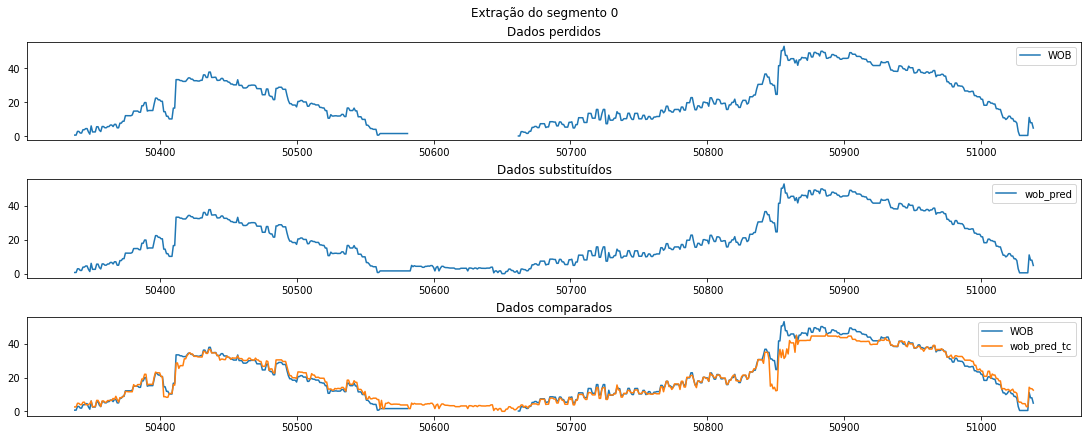

In [119]:
# Plot and print missing data and the values have been replaced to be compared.
plot_predictions(df, segment=0)
#print_estimtion(df, segment=0)

49035    4.36493
49036    3.80403
49037    2.68068
49038    2.68068
49039    2.68068
          ...   
50333    2.24200
50334    3.54951
50335    3.54951
50336    3.54951
50337    1.59438
Name: WOB, Length: 1303, dtype: float64


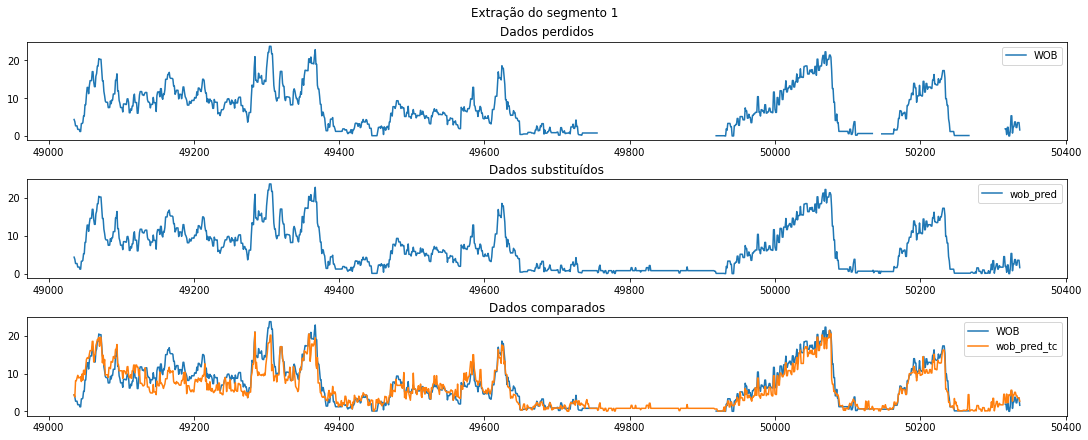

In [120]:
plot_predictions(df, segment=1)
#print_estimtion(df, segment=1)

In [121]:
finish = time()
total_time = round((finish - start) / 60, 2)
unit = 'min'
if total_time > 60:
    total_time = total_time / 60
    unit = 'hrs'

now = datetime.now()
finish = datetime.strftime(now, '%d/%m/%Y, %H:%M')
print(f'{finish} | Total time {round(total_time, 2)} {unit}')

10/06/2022, 00:15 | Total time 10.64 min
